This is a retail E-commerce dataset that's contains transactions records. 

The main goal is to understand the customers behavior and for this we'll split in two technics:

1. Introduce the RFM (Recency, Frequency and Monetary) method to analyze the distribution and classifying them according to Cluster algorithm. 

2. Apply the Cohort Analysis and view the customers retention.

In [1]:
# Importing necessary libs
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# File path
for dirname, _, filesname in os.walk('/kaggle/input'):
    for filename in filesname:
        print(os.path.join(dirname, filename))

/kaggle/input/ecommerce-data/data.csv


In [3]:
# First dataset view
retail = pd.read_csv('/kaggle/input/ecommerce-data/data.csv', encoding='unicode_escape')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Basic informations

In [4]:
print(f'Lines = {retail.shape[0]} | Columns = {retail.shape[1]}')

Lines = 541909 | Columns = 8


In [5]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Checking:
- 'CustomerID' null values.
- 'Quantity' and 'UnitPrice' lower than zero.

In [7]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
retail_low = retail.query("Quantity < 0 or UnitPrice < 0")
retail_low.shape[0]

10626

# Data Manipulation
1. Droping null and negative values.
2. Transforming 'InvoiceDate' to datetime dtype.
3. Create a new column 'Invoice Revenue' for customers classification

In [9]:
# Droping null values
retail.dropna(inplace=True)

# Droping negative values
retail = retail.query("Quantity > 0 and UnitPrice > 0")

# Dtype changing
retail.InvoiceDate = pd.to_datetime(retail.InvoiceDate)

# 'InvoiceRevenue' column
retail['InvoiceRevenue'] = retail['Quantity'] * retail['UnitPrice']

Unfortunately we've got to drop a lot of lines from the dataset to keep foward.<br>In a real business case it would be prudent to get in touch with the DW and solve this problem.<br>The analysis won't be as precise as it could be.

# RFM Method
RFM is a method to segment customers (very comum in marketing) based on purchasing behavior alowing datadriven strategies for each type of customers group. It takes into account three metrics:
- Recency: How long from the last purchasing.
- Frequency: Purchase frequency.
- Monetary: How much it spend.
<br>

Combined with RFM, it's possible to apply the Cluster algorithm, a noun supervised machine learning technic that cluster a group of objects based on their characteristics, i.e, understand each type of customers segmentation. We will develop the K-means algorithm, one of the Cluster algorithm technics.

First goal is to find the three metrics mentioned.

Let's find **Recency**.
- Create new dataframe.
- Define the most recent date.
- Calculate difference between the most recent date from the others.

In [10]:
recency = retail[['CustomerID', 'InvoiceDate']].groupby('CustomerID')['InvoiceDate'].agg('max').reset_index()

cur_time = recency.InvoiceDate.max()

def month_calc(cur_time, datetime_val):
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)

recency['Recency'] = recency.InvoiceDate.apply(lambda datetime_val: month_calc(cur_time, datetime_val))

recency.head()

,CustomerID,InvoiceDate,Recency
0,12346.0,2011-01-18 10:01:00,11
1,12347.0,2011-12-07 15:52:00,0
2,12348.0,2011-09-25 13:13:00,3
3,12349.0,2011-11-21 09:51:00,1
4,12350.0,2011-02-02 16:01:00,10


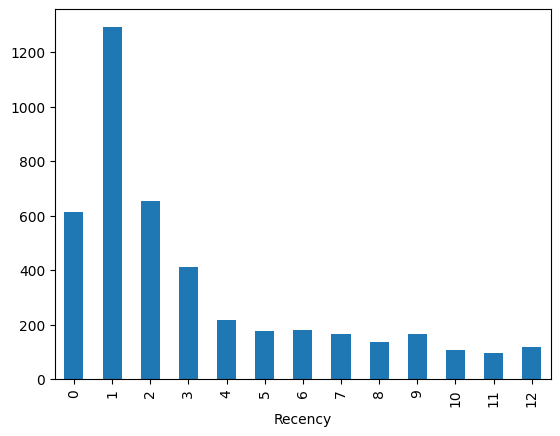

In [11]:
recency.Recency.value_counts().sort_index().plot.bar();

Let's find **Frequency** e **Monetary**.

- Setting the columns and grouping by CustomersID
- Counting/Mean from 'InvoiceNo'/'InvoiceRevenue' columns.

In [12]:
freq_mon = retail[['CustomerID', 'InvoiceNo', 'InvoiceRevenue']]
freq_mon = freq_mon.groupby('CustomerID')[['InvoiceNo', 'InvoiceRevenue']].agg(
    {'InvoiceNo': 'count', 'InvoiceRevenue': 'mean'}).reset_index()
freq_mon = freq_mon.round(2)
freq_mon.head()

,CustomerID,InvoiceNo,InvoiceRevenue
0,12346.0,1,77183.60
1,12347.0,182,23.68
2,12348.0,31,57.98
3,12349.0,73,24.08
4,12350.0,17,19.67


The three metrics were found, let's merge and establish the new dataframe.

In [13]:
rfm = recency.merge(freq_mon, on='CustomerID', how='left')
rfm = rfm.rename(columns={'InvoiceNo': 'Frequency', 'InvoiceRevenue': 'Monetary'})
rfm.head()

,CustomerID,InvoiceDate,Recency,Frequency,Monetary
0,12346.0,2011-01-18 10:01:00,11,1,77183.60
1,12347.0,2011-12-07 15:52:00,0,182,23.68
2,12348.0,2011-09-25 13:13:00,3,31,57.98
3,12349.0,2011-11-21 09:51:00,1,73,24.08
4,12350.0,2011-02-02 16:01:00,10,17,19.67


# KMeans algorithm

After establish the RFM dataframe, we gonna apply the KMeans, a cluster algorithm.
<br>
It's a noun supervised machine learning algorithm thats split a group of objects according to their characteristics. In this case there is no target.
<br>
The main goal is to divede as better as possible our costumers, i.e., find the optimal K number (cluster).
<br>


***But how does it work?***
<br>
- We need to define a number for K. A popular solution for this is the 'Elbow' method.
- Afterwards, a random position for the centroids will be determined.
- For each client, It will be calculate the closest distance regarding to the centroid (Euclidian distance).
- The centroids will be repositioned according to the sum of the square distance between points in a cluster and the cluster centroid untill the centroid position stop changing.


In [14]:
# Adjusting the scale
from sklearn.preprocessing import StandardScaler

feat_col = ['Recency', 'Frequency', 'Monetary']
stand_rfm = rfm.copy()

scaler = StandardScaler()
scaler.fit(rfm[feat_col])

stand_feat = scaler.transform(rfm[feat_col])
stand_rfm[feat_col] = stand_feat

Text(0.5, 1.0, 'Elbow Method')

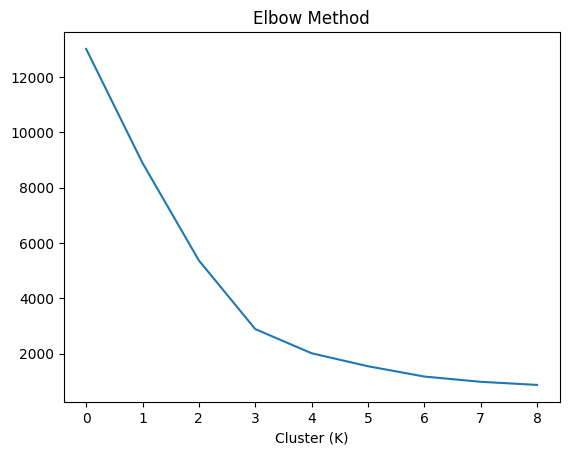

In [15]:
# Elbow method
from sklearn.cluster import KMeans

wcss = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, init='k-means++')
    kmeans.fit(stand_rfm[feat_col])
    wcss.append(kmeans.inertia_)

plt.plot(wcss)
plt.xlabel('Cluster (K)')
plt.title('Elbow Method')

Elbow method is a popular way to find the optimal K, however the intepretation is very subjective. It's indicate to validate with another method, such as the Silhouette score.
<br>
Let's point number 3 as K.


In [16]:
# Labeling Clients by Cluster
kmeans = KMeans(n_clusters=3, init='k-means++')
kmeans.fit(stand_rfm[feat_col])

rfm['Cluster'] = kmeans.labels_

rfm.head()

,CustomerID,InvoiceDate,Recency,Frequency,Monetary,Cluster
0,12346.0,2011-01-18 10:01:00,11,1,77183.60,2
1,12347.0,2011-12-07 15:52:00,0,182,23.68,0
2,12348.0,2011-09-25 13:13:00,3,31,57.98,0
3,12349.0,2011-11-21 09:51:00,1,73,24.08,0
4,12350.0,2011-02-02 16:01:00,10,17,19.67,1


In [17]:
rfm_cluster = rfm.groupby('Cluster')[['CustomerID', 'Recency', 'Frequency', 'Monetary']].agg({
    'CustomerID': 'nunique',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
})
rfm_cluster.rename(columns={'CustomerID': 'Total Customers'})
rfm_cluster['Status'] = ['Profitable', 'Churn', 'Potencial']
rfm_cluster

,CustomerID,Recency,Frequency,Monetary,Status
Cluster,,,,,
0,3194,1.481215,114.380401,32.510783,Profitable
1,1142,8.088441,28.501751,51.947215,Churn
2,2,5.500000,2.000000,66670.550000,Potencial


As you can see, the Potencial clients has only two costumers. It would necessary exlude this sample from dataset or even depply search  better costumers segmentation.

<Axes: xlabel='Cluster', ylabel='Recency'>

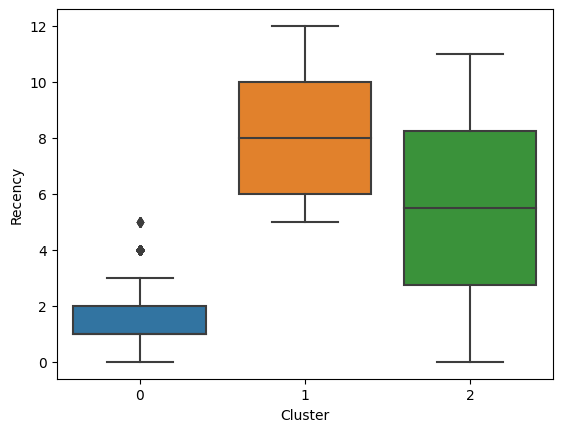

In [29]:
# Let's view the distribuiton for each Status

sns.boxplot(data=rfm, x='Cluster', y='Recency')

<Axes: xlabel='Cluster', ylabel='Frequency'>

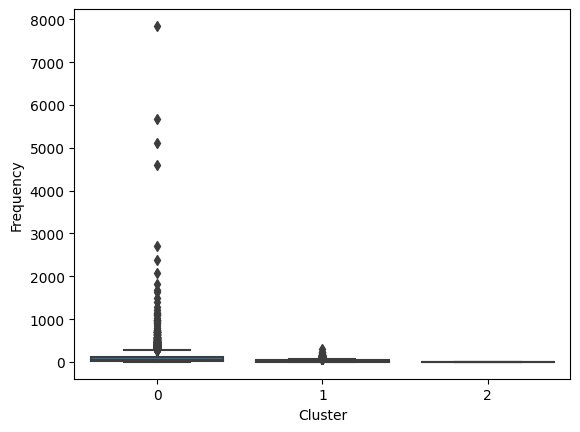

In [19]:
sns.boxplot(data=rfm, x='Cluster', y='Frequency')

<Axes: xlabel='Cluster', ylabel='Monetary'>

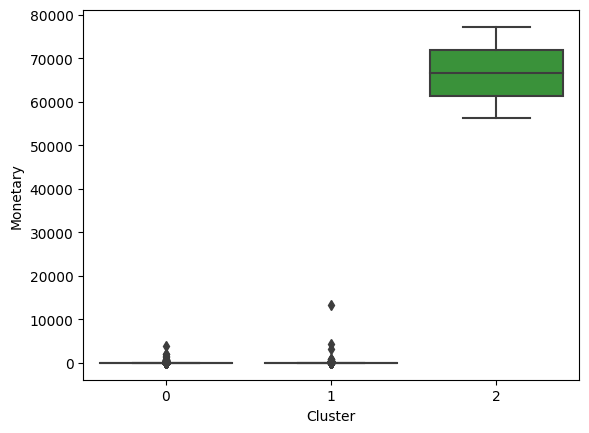

In [20]:
sns.boxplot(data=rfm, x='Cluster', y='Monetary')

# Cohort Analysis

It's an interesting method that's enable a clear view of costumers behavior during a similar event in a period of time.
<br>
In our case, we want to understand the costumers retantion according to their frequency purchasing through out the months

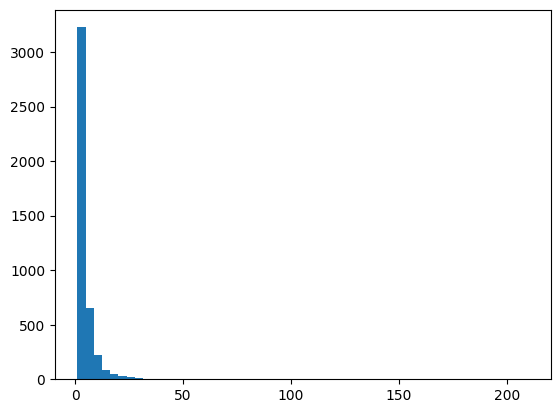

In [21]:
# Counting InvoiceNo according to each CostumerID.
df_cohort = retail[['InvoiceDate', 'InvoiceNo', 'CustomerID']].dropna()
invoice_costomer = df_cohort.groupby('CustomerID')['InvoiceDate'].nunique()
plt.hist(invoice_costomer, bins=55)
plt.show()

In [22]:
# Let's create a column with the month to facilitate the costumers Cohort
df_cohort['Month'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort.head()

,InvoiceDate,InvoiceNo,CustomerID,Month
0,2010-12-01 08:26:00,536365,17850.0,2010-12
1,2010-12-01 08:26:00,536365,17850.0,2010-12
2,2010-12-01 08:26:00,536365,17850.0,2010-12
3,2010-12-01 08:26:00,536365,17850.0,2010-12
4,2010-12-01 08:26:00,536365,17850.0,2010-12


In [23]:
# Finding the Cohort for each client, i.e, the first customer acquisition into dataframe
df_cohort['Cohort'] = df_cohort.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
df_cohort.head()

,InvoiceDate,InvoiceNo,CustomerID,Month,Cohort
0,2010-12-01 08:26:00,536365,17850.0,2010-12,2010-12
1,2010-12-01 08:26:00,536365,17850.0,2010-12,2010-12
2,2010-12-01 08:26:00,536365,17850.0,2010-12,2010-12
3,2010-12-01 08:26:00,536365,17850.0,2010-12,2010-12
4,2010-12-01 08:26:00,536365,17850.0,2010-12,2010-12


In [24]:
# Counting the customers amount for each month 
cohort = df_cohort.groupby(['Cohort', 'Month']).agg(n_customer=('CustomerID', 'nunique')).reset_index()

# Ranking month
cohort['Period'] = (cohort.Month - cohort.Cohort).apply(lambda x: x.n)

cohort.head()

,Cohort,Month,n_customer,Period
0,2010-12,2010-12,885,0
1,2010-12,2011-01,324,1
2,2010-12,2011-02,286,2
3,2010-12,2011-03,340,3
4,2010-12,2011-04,321,4


In [25]:
# Creating a Pivot Table
cohort_pivot = cohort.pivot_table(index='Cohort', columns='Period', values='n_customer')

# Setting the Column 0 as denominator to transform the values into porcentage
cohort_denominator = cohort_pivot.iloc[:,0]

# Creating a porcentage Pivot Table
porcentage_pivot = cohort_pivot.divide(cohort_denominator, axis=0)

porcentage_pivot

Period,0,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,,
2010-12,1.0,0.366102,0.323164,0.384181,0.362712,0.397740,0.362712,0.349153,0.353672,0.395480,0.374011,0.502825,0.265537
2011-01,1.0,0.220624,0.266187,0.230216,0.321343,0.287770,0.247002,0.242206,0.299760,0.326139,0.364508,0.117506,NaN
2011-02,1.0,0.186842,0.186842,0.284211,0.271053,0.247368,0.252632,0.278947,0.247368,0.305263,0.068421,NaN,NaN
2011-03,1.0,0.150442,0.252212,0.199115,0.223451,0.168142,0.267699,0.230088,0.278761,0.086283,NaN,NaN,NaN
2011-04,1.0,0.213333,0.203333,0.210000,0.196667,0.226667,0.216667,0.260000,0.073333,NaN,NaN,NaN,NaN
2011-05,1.0,0.190141,0.172535,0.172535,0.207746,0.232394,0.264085,0.095070,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.173554,0.157025,0.264463,0.231405,0.334711,0.095041,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.180851,0.207447,0.223404,0.271277,0.111702,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.207101,0.248521,0.242604,0.124260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


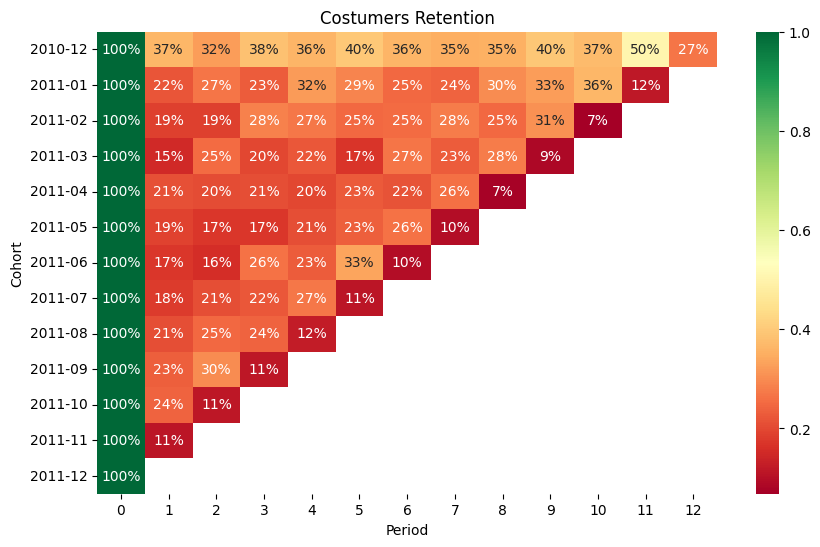

In [26]:
# Creating a heatmap

_ = plt.subplots(figsize=(10,6))
_ = sns.heatmap(data=porcentage_pivot,
               mask=porcentage_pivot.isnull(),
               annot=True,
               fmt='.0%',
               cmap='RdYlGn')
_ = plt.title('Costumers Retention')

# Conclusion

In this analysis we applyied two popular methods to understand the customer behavior according to their purchasing records.
With the RFM method, we were able to divide the clients into 3 cluster applying the Kmeans technic, a noun supervised machine learning algorithm.
Most part of clients has a low average expense but a high frequency, on the other hand, a second group with a little increase average expense and low frequency,indicating a possible churn. A third group was clustered but only with to customers, it's not prudent consider it.

<br>
The Cohort analysis demonstrate the purchasing behavior, it's clearly to view in the heatmap the access drop through out the months, i.e., a low retention. Marketing team can develop strategies to increase the retention/purchasing with datadriven decisions. It's import to understand that more than attract new clients, is to certify the access to customers who already have.